# Image Compression using Autoencoders with BPSK

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* joint compression and error protection of images by auto-encoders
* generation of BPSK symbols using stochastic quantizers
* transmission over a binary symmetric channel (BSC)

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

Import and load MNIST dataset

In [2]:
mnist = tf.keras.datasets.mnist

# only load the images, we are not interested in the training data
(x_train, _),(x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

image_size = x_train.shape[1]

x_test_flat = np.array([np.reshape(x_test[k,:,:], image_size*image_size) for k in range(x_test.shape[0])])

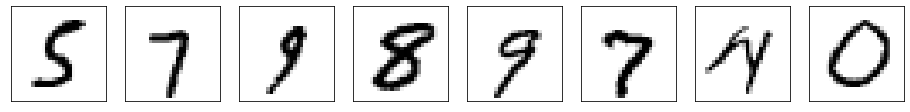

In [3]:
#print 8 random images
plt.figure(figsize=(16,2))
for k in range(8):
    plt.subplot(1,8,k+1)
    plt.imshow(x_train[np.random.randint(x_train.shape[0])], interpolation='nearest', cmap='binary')
    plt.xticks(())
    plt.yticks(())

In [5]:
# target compression rate
bit_per_image = 24

# BSC error probability
Pe = 0.05


# Network parameters
hidden_encoder_1 = 500
hidden_encoder_2 = 250
hidden_encoder_3 = 100

hidden_decoder_1 = 100
hidden_decoder_2 = 250
hidden_decoder_3 = 500

tf.reset_default_graph()

training_data = tf.placeholder(tf.float32, [None, image_size*image_size])

valid_data = tf.constant(x_test_flat, dtype=tf.float32)


weights = { 'We1' : tf.Variable(tf.truncated_normal([image_size*image_size, hidden_encoder_1], stddev=0.1)),
            'We2' : tf.Variable(tf.truncated_normal([hidden_encoder_1, hidden_encoder_2], stddev=0.1)),
            'We3' : tf.Variable(tf.truncated_normal([hidden_encoder_2, hidden_encoder_3], stddev=0.1)),
            'We4' : tf.Variable(tf.truncated_normal([hidden_encoder_3, bit_per_image], stddev=0.1)),
            'Wd1' : tf.Variable(tf.truncated_normal([bit_per_image, hidden_decoder_1], stddev=0.1)),
            'Wd2' : tf.Variable(tf.truncated_normal([hidden_decoder_1, hidden_decoder_2], stddev=0.1)),
            'Wd3' : tf.Variable(tf.truncated_normal([hidden_decoder_2, hidden_decoder_3], stddev=0.1)),
            'Wd4' : tf.Variable(tf.truncated_normal([hidden_decoder_3, image_size*image_size], stddev=0.1)),
          }

biases = {  'be1' : tf.Variable(tf.truncated_normal([hidden_encoder_1], stddev=0.1)),
            'be2' : tf.Variable(tf.truncated_normal([hidden_encoder_2], stddev=0.1)),
            'be3' : tf.Variable(tf.truncated_normal([hidden_encoder_3], stddev=0.1)),
            'be4' : tf.Variable(tf.truncated_normal([bit_per_image], stddev=0.1)),
            'bd1' : tf.Variable(tf.truncated_normal([hidden_decoder_1], stddev=0.1)),
            'bd2' : tf.Variable(tf.truncated_normal([hidden_decoder_2], stddev=0.1)),
            'bd3' : tf.Variable(tf.truncated_normal([hidden_decoder_3], stddev=0.1)),
            'bd4' : tf.Variable(tf.truncated_normal([image_size*image_size], stddev=0.1)),
          }

def binarizer(input):
    prob = tf.truediv(tf.add(input, 1.0), 2.0)
    bernoulli = tf.distributions.Bernoulli(probs=prob, dtype=tf.float32)
    return 2*bernoulli.sample() - 1

def binarizer_deterministic(input):
    return tf.sign(input)

def encoder(batch):
    temp = tf.nn.elu(tf.matmul(batch, weights['We1']) + biases['be1'])
    temp = tf.nn.elu(tf.matmul(temp, weights['We2']) + biases['be2'])
    temp = tf.nn.elu(tf.matmul(temp, weights['We3']) + biases['be3'])
    output = tf.nn.softsign(tf.matmul(temp, weights['We4']) + biases['be4'])
    return output

def decoder(batch):
    temp = tf.nn.elu(tf.matmul(batch, weights['Wd1']) + biases['bd1'])
    temp = tf.nn.elu(tf.matmul(temp, weights['Wd2']) + biases['bd2'])
    temp = tf.nn.elu(tf.matmul(temp, weights['Wd3']) + biases['bd3'])
    #output = 1+0.5*tf.nn.softsign(tf.matmul(temp, weights['Wd4']) + biases['bd4'])
    output = tf.nn.sigmoid(tf.matmul(temp, weights['Wd4']) + biases['bd4'])
    return output

encoded = encoder(training_data)
# random binarization in training
ti = tf.identity(encoded)
compressed = ti + tf.stop_gradient(binarizer(encoded) - ti)

# add error pattern
error_tensor = tf.distributions.Bernoulli(probs = Pe * tf.ones_like(compressed), dtype=tf.float32).sample() 
received = tf.math.multiply( compressed, 1 - 2*error_tensor)

reconstructed = decoder(received)

encoded_test = encoder(valid_data)
compressed_test = binarizer_deterministic(encoded_test)
error_tensor_test = tf.distributions.Bernoulli(probs = Pe * tf.ones_like(compressed_test), dtype=tf.float32).sample()
received_test = tf.math.multiply( compressed_test, 1 - 2*error_tensor_test )
reconstructed_test = decoder(received_test)
loss_test = tf.reduce_mean(tf.square(valid_data - reconstructed_test))

reconstructed_test_noerror = decoder(compressed_test)


loss = tf.losses.mean_squared_error(training_data, reconstructed)

train_step = tf.train.AdamOptimizer().minimize(loss)

init = tf.global_variables_initializer()


# generator to reconstruct some images from generic input
generic_input = tf.placeholder(tf.float32, [None, bit_per_image])
generic_reconstructed = decoder(generic_input)

Helper function to get a random mini-batch of images

In [6]:
def get_batch(x, batch_size):
    idxs = np.random.randint(0, x.shape[0], (batch_size))
    return np.array([np.reshape(x[k,:,:], image_size*image_size) for k in idxs])

In [7]:
batch_size = 250

# Create session and initialize all variables
session = tf.InteractiveSession()
session.run(init)

# Training loop
for it in range(25000):  # Original paper does 50k iterations  
    mini_batch = get_batch(x_train, batch_size)

    session.run(train_step, feed_dict = { training_data : mini_batch })    

    
    if it % 1000 == 0:
        print('It %d: Loss %1.5f' % (it, loss_test.eval()))

It 0: Loss 0.23889
It 1000: Loss 0.03484
It 2000: Loss 0.03270
It 3000: Loss 0.03191
It 4000: Loss 0.03090
It 5000: Loss 0.03045
It 6000: Loss 0.03013
It 7000: Loss 0.02988
It 8000: Loss 0.02972
It 9000: Loss 0.02939
It 10000: Loss 0.02935
It 11000: Loss 0.02924
It 12000: Loss 0.02903
It 13000: Loss 0.02884
It 14000: Loss 0.02861
It 15000: Loss 0.02871
It 16000: Loss 0.02856
It 17000: Loss 0.02863
It 18000: Loss 0.02839
It 19000: Loss 0.02840
It 20000: Loss 0.02834
It 21000: Loss 0.02830
It 22000: Loss 0.02820
It 23000: Loss 0.02839
It 24000: Loss 0.02821


Image 1:  [1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
Image 2:  [1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1.]
Image 3:  [1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
Image 4:  [0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1.]
Image 5:  [1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.]
Image 6:  [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0.]
Image 7:  [0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.]
Image 8:  [0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.]


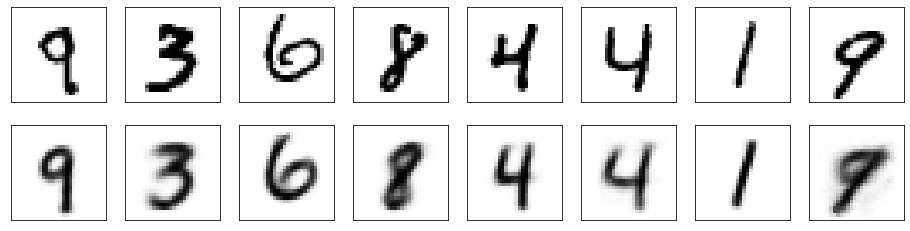

In [8]:
valid_images =  reconstructed_test.eval()
valid_binary = 0.5*(1 - compressed_test.eval())   # from bipolar (BPSK) to binary
# show 8 images and their reconstructed versions
plt.figure(figsize=(16,4))
idxs = np.random.randint(x_test.shape[0],size=8)
for k in range(8):
    plt.subplot(2,8,k+1)    
    plt.imshow(np.reshape(x_test_flat[idxs[k]], (image_size,image_size)), interpolation='nearest', cmap='binary')    
    plt.xticks(())
    plt.yticks(())
    
    plt.subplot(2,8,k+1+8)
    plt.imshow(np.reshape(valid_images[idxs[k]], (image_size,image_size)), interpolation='nearest', cmap='binary')    
    plt.xticks(())
    plt.yticks(())

# print binary data of the images
for k in range(8):
    print('Image %d: ' % (k+1), valid_binary[idxs[k],:])

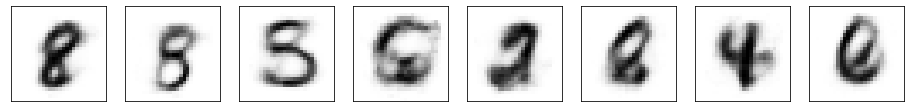

In [22]:
# generate 8 arbitary images just by sampling random bit strings
random_data = 1-2*np.random.randint(2,size=(8,bit_per_image))
generated_images = generic_reconstructed.eval(feed_dict = { generic_input : random_data })
plt.figure(figsize=(16,2))
for k in range(8):
    plt.subplot(1,8,k+1)
    plt.imshow(np.reshape(generated_images[k],(image_size,image_size)), interpolation='nearest', cmap='binary')
    plt.xticks(())
    plt.yticks(())

In [136]:
session.close()